### (Home credit competition 중심으로)
## 3.1 특성공학 - Feature engineering
---
### 소스 및 데이터는 아래 kaggle을 참조하였습니다. 
* 캐글 주소 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* 해당 커널의 한글 번역은 파파고와 구글을 활용하였습니다.
___

In [1]:
# 라이브러리 
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
# 데이터 셋
app_train = pd.read_csv('d:/Projects/Cp/input/application_train.csv')
app_test = pd.read_csv('d:/Projects/Cp/input/application_test.csv')

In [3]:
#  레이블 인코딩 
le = LabelEncoder()
le_count = 0

for col in app_train:    
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2: 
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col]  = le.transform(app_test [col])            
            le_count += 1

In [4]:
# 원 핫 인코딩
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [5]:
# 원 핫 인코딩 후 훈련/테스트 용 데이터 열(컬럼) 일치화

# TARGET(대출금 상환여부)열 따로 보관
train_labels = app_train['TARGET']

# 열(컬럼)기준 데이터 정렬하여 서로 없는 열(컬럼) 삭제
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# 학습용 데이터에 TARGET(대출금 상환여부)열 추가
app_train['TARGET'] = train_labels

In [6]:
# 취업일(DAYS_EMPLOYED) 이상치 데이터 처리

# 훈련용 셋
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 테스트용 셋
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [7]:
#편의를 위해 DAYS_BIRTH의 절대값을 취하여 양수를 만듭니다
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

In [8]:
# 연령대 정보를 다른 데이터프레임에 저장하고 년으로 환산
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 나이 구간 설정
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

#### 특성공학 (Feature Engineering)

> 특정 애츨리케이션에 가장 적합한 데이터 표현을 찾는 것
>
> (출처 : 파이썬 라이브러리를 활용한 머신러닝, 안드레아스 뮐러, 세라 가이도 지음, 한빛미디어, 2017)


* Kaggle 대회는 특성 공학, 즉 데이터에서 가장 유용한 기능을 만들 수 있는 사람들에의해 승리자가 됩니다. 
* 사실 적어도 구조화된 데이터를 위한 이기는 모델은 그래이언트 부스팅(gradient boosting)의 변형인 경향이 있습니다.
* 이는 기계 학습의 패턴 중 하나를 상징합니다. 즉 특성공학(Feature Engineering)은 모델 구축 및 하이퍼 파라미터 조정(hyperparameter tuning)보다 성능에 더 큰 영향을 미칩니다.
* 다음은 이 주제에 대한 훌륭한 기사 입니다.
> Andrew Ng : "applied machine learning is basically feature engineering."
>           : "적용된 기계 학습은 기본적으로 특성 공학입니다."

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

* 우리는 데이터 분석 시 사용할 많은 특성공학이 있지만 이 노트북에서는 두 가지 간단한 피쳐 구축 방법을 사용 할 것이다.

    * 다항식 피쳐
    * 도메인 지식 피쳐

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

Jake VanderPlas writes about polynomial features in his excellent book Python for Data Science for those who want more information.

In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

#### 다항식 특성

In [9]:
# 다항식 피쳐를 새로운 데이터프레임 만들기
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 누락된 값 처리
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# 누락된 값을 중앙값으로 채움
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# 지정된 차수의 다항식 객체 만들기
poly_transformer = PolynomialFeatures(degree = 3)

In [10]:
# 다항식 특성 훈련
poly_transformer.fit(poly_features)

# 피쳐 변환
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


* 많은 새로운 피쳐가 생성되었고 이름을 확인하려면 feature_names 메서드 사용

In [11]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

* 차수가 3으로 35개의 피쳐가 생성 되었습니다.
* 새로운 피쳐들 중 어떤것이 대출상환여부(Target)와 관계가 있는지 확인 할 수 있습니다.

In [12]:
# 피쳐의 데이터 프레임 poly_features 생성
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# poly_features 데이터프레임에 대출상환여부(target) 추가
poly_features['TARGET'] = poly_target

# 대출상환여부(target) 상관 관계 찾기
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# 가장 큰 음의 상관관계와 양의 상관관계 표시
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [13]:
# poly_features_test 데이터프레임에 테스트 피쳐 넣기
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 다항식 피쳐를 훈련용 데이터 프레임에 병합
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# 다항식 피쳐를 테스트용 데이터프레임에 병합
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# 데이터프레임 정렬
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


#### Domain Knowledge Features
* 내가 신용 전문가가 아니기 때문에 이것을 "도메인 지식"이라고 부르는 것은 전적으로 옳지 않을 수도 있지만
* 아마도 우리는 이것을 "제한된 금융 지식을 적용하려는 시도"라고 부를 수 있을 것입니다. 
* 이러한 관점에서, 우리는 고객의 대출에 채무불이행이 발생하는지 여부에 대해 중요한 것으로 생각되는 것을 포착하려고 하는 몇 가지 특징을 만들 수 있습니다. 
___
* 여기서 저는 Aguiar에 의해 영감을 받은 5가지 특징을 사용할 것입니다.


    * CREDIT_INCOME_PERCENT: 대출신청자의 소득 대비 신용 금액의 백분율
    * ANNUITY_INCOME_PERCENT: 대출신청자의 소득 대비 대출 연금의 비율
    * CREDIT_TERM: 월별 지불 기간(연금이 월별 금액이므로)
    * DAYS_EMPLOYED_PERCENT: 대출신청자의 나이와 관련하여 고용 일수의 백분율


In [14]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [15]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### 새로운 변수들의 시각화
* 우리는 이러한 도메인 지식 변수를 그래프에서 시각적으로 탐구해야 한다. 
* 이 모든 것에 대해 우리는 TARGET의 값으로 색칠된 동일한 KDE 그림을 만들 것이다.

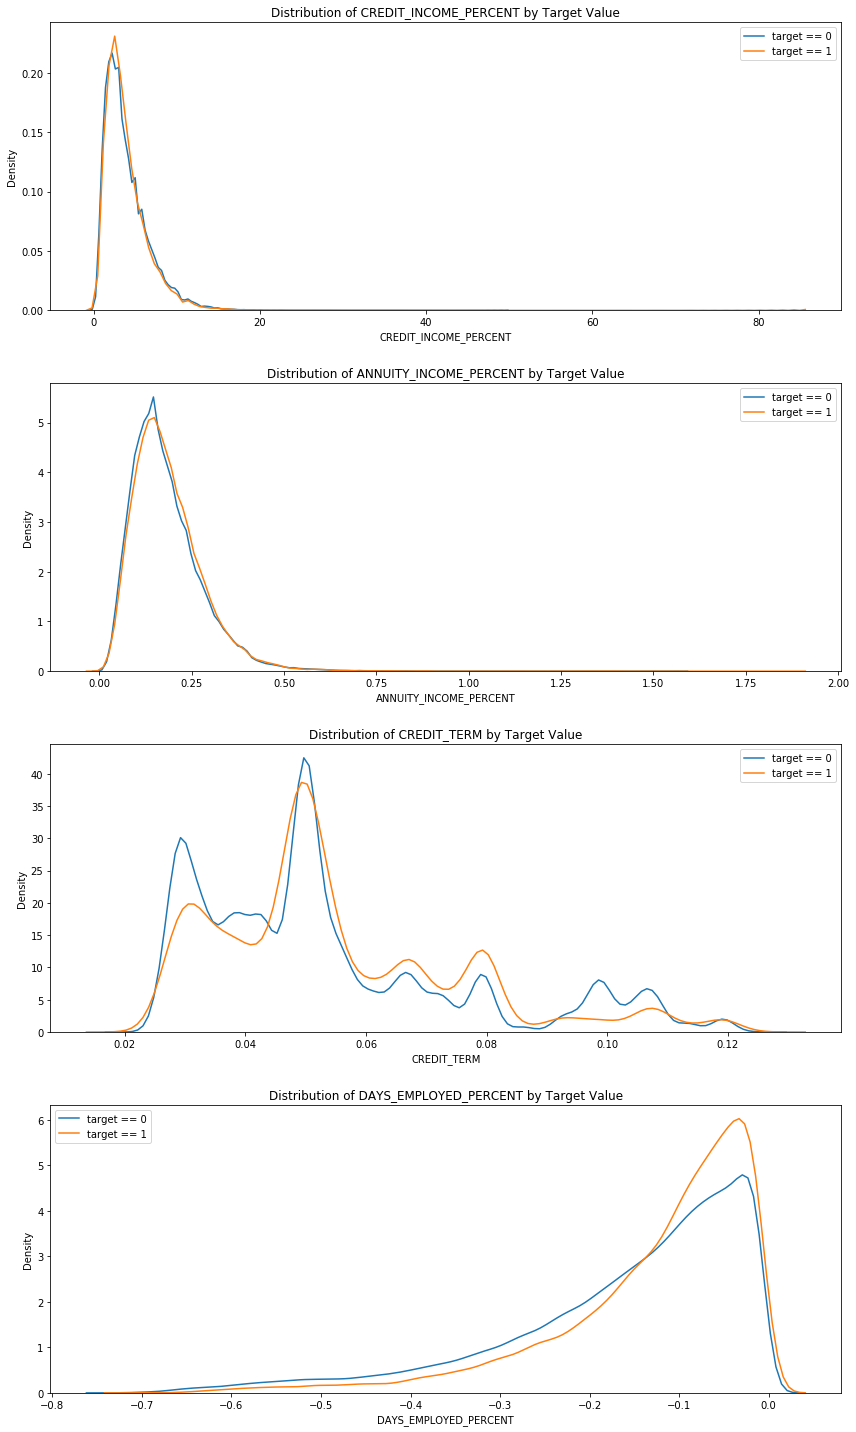

In [16]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
        
    plt.subplot(4, 1, i + 1)
    # 제때 상환한 대출금 플롯
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # 제때 상환하지 못한 대출금 플롯
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

* 대출금 상환여부(Target) - 0 : 상환, 1 : 미상환
___
* 이러한 새로운 특징들이 유용할 것이라고 미리 말하기는 어렵다. 
* 확실하게 말할 수 있는 유일한 방법은 그것들을 시험해 보는것이다.